In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, QTable, hstack
from myspace import MySpace
from sklearn.mixture import GaussianMixture


In [2]:
import sklearn
import jax
import numpy
import scipy

print('scikit-learn', sklearn.__version__)
print('jax', jax.__version__)
print('numpy', numpy.__version__)
print('scipy', scipy.__version__)

#Output:
#scikit-learn 0.23.2
#jax 0.2.5
#numpy 1.19.1
#scipy 1.5.0

scikit-learn 0.23.2
jax 0.2.5
numpy 1.16.4
scipy 1.3.0


In [3]:
gaia = QTable.read('../Downloads/RV-all-result.fits', format='fits')

In [4]:
from zero_point import zpt
zpt.load_tables()

gmag = gaia['phot_g_mean_mag'].value
nueffused = gaia['nu_eff_used_in_astrometry'].value
psc = gaia['pseudocolour'].value
sinbeta = np.sin(np.deg2rad(gaia['ecl_lat'].value))
soltype = gaia['astrometric_params_solved']

zpvals = zpt.get_zpt(gmag, nueffused, psc, sinbeta, soltype)
cparallax=gaia['parallax'].value-zpvals

/anaconda3/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:203: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(phot_g_mean_mag >= 21) or np.any(phot_g_mean_mag <= 6):
/anaconda3/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:203: RuntimeWarning: invalid value encountered in less_equal
  if np.any(phot_g_mean_mag >= 21) or np.any(phot_g_mean_mag <= 6):
/anaconda3/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:208: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/zero_point_brugalada-0.0.1-py3.7.egg/zero_point/zpt.py:223: UserWarning: The nu_eff_used_in_astrometry of some of the 5p source(s) is outside the expected range (1.1-1.9 
      

In [5]:
qindx=(gaia['parallax_over_error']>4.)


In [6]:
def make_anim_xv(XX,VV,tensorsx,myspacex,tensorsxv,myspacexv,gs=150):
    
    
    _cyl = gal.represent_as('cylindrical')
    mask2_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc) & (_cyl.rho > 200*u.pc)
    disk_vmask2=(np.sqrt(VV[:,0]**2+VV[:,1]**2+VV[:,2]**2)<200.)
    
    rindx=(disk_vmask2)*(mask2_r500)
    for i in range(0,36):
        wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)
        if i==34:
            wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)+rindx*(_cyl.phi+np.pi*u.rad>0.)*(_cyl.phi+np.pi*u.rad<((1)*np.pi/18.)*u.rad)
        if i==35:
            wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)+rindx*(_cyl.phi+np.pi*u.rad>0.)*(_cyl.phi+np.pi*u.rad<((2)*np.pi/18.)*u.rad)
        print(wedgedex.sum(),'stars in wedge',i)

        fixx=myspacex.get_model_v(tensorsx,VV[wedgedex],XX[wedgedex])
        fixxv=myspacexv.get_model_v(tensorsxv,VV[wedgedex],XX[wedgedex])

        f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15,15))
        ax1.hist2d(XX[:,0][wedgedex],XX[:,1][wedgedex],range=[[-500,500],[-500.,500.]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax1.set_xlabel(r'$X\ (\mathrm{kpc})$',fontsize=20)
        ax1.set_ylabel(r'$Y\ (\mathrm{kpc})$',fontsize=20)
        ax1.set_xlim(-500.,500.)
        ax1.set_ylim(-500.,500.)
        ax1.set_title(r'$\mathrm{Selected\ area}$',fontsize=20)
        ax2.hist2d(VV[:,0][wedgedex],VV[:,1][wedgedex],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax2.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax2.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax2.set_xlim(-125,125)
        ax2.set_ylim(-125,125)
        ax2.set_title(r'$\mathrm{No\ correction}$',fontsize=20)
        ax3.hist2d(fixx[:,0],fixx[:,1],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax3.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax3.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax3.set_xlim(-125,125)
        ax3.set_ylim(-125,125)
        ax3.set_title(r'$\mathrm{x\ correction}$',fontsize=20)
        ax4.hist2d(fixxv[:,0],fixxv[:,1],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax4.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax4.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax4.set_xlim(-125,125)
        ax4.set_ylim(-125,125)
        ax4.set_title(r'$\mathrm{xv\ correction}$',fontsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax2.tick_params(axis='both', which='major', labelsize=15)
        ax3.tick_params(axis='both', which='major', labelsize=15)
        ax4.tick_params(axis='both', which='major', labelsize=15)
        plt.savefig('gaiao'+str("{:02d}".format(i))+'.pdf',bbox_inches='tight')
        plt.close()

    os.system('convert -delay 5 -loop 0 gaiao*.pdf orders.gif')

In [26]:
def make_anim_justx(XX,VV,tensorsx,myspacex,gs=150):
    
    
    _cyl = gal.represent_as('cylindrical')
    mask2_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc) & (_cyl.rho > 200*u.pc)
    disk_vmask2=(np.sqrt(VV[:,0]**2+VV[:,1]**2+VV[:,2]**2)<100.)
    
    rindx=(disk_vmask2)*(mask2_r500)
    for i in range(0,36):
        wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)
        if i==34:
            wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)+rindx*(_cyl.phi+np.pi*u.rad>0.)*(_cyl.phi+np.pi*u.rad<((1)*np.pi/18.)*u.rad)
        if i==35:
            wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)+rindx*(_cyl.phi+np.pi*u.rad>0.)*(_cyl.phi+np.pi*u.rad<((2)*np.pi/18.)*u.rad)
        print(wedgedex.sum(),'stars in wedge',i)

        fixx=myspacex.get_model_v(tensorsx,VV[wedgedex],XX[wedgedex])


        f, ((ax1,ax2,ax3)) = plt.subplots(1, 3, figsize=(21,7))
        ax1.hist2d(XX[:,0][wedgedex],XX[:,1][wedgedex],range=[[-0.5,0.5],[-0.5,0.5]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax1.set_xlabel(r'$X\ (\mathrm{kpc})$',fontsize=20)
        ax1.set_ylabel(r'$Y\ (\mathrm{kpc})$',fontsize=20)
        ax1.set_xlim(-0.5,0.5)
        ax1.set_ylim(-0.5,0.5)
        ax1.set_title(r'$\mathrm{Selected\ area}$',fontsize=20)
        ax2.hist2d(VV[:,0][wedgedex],VV[:,1][wedgedex],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax2.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        #ax2.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax2.set_xlim(-125,125)
        ax2.set_ylim(-125,125)
        ax2.set_title(r'$\mathrm{No\ correction}$',fontsize=20)
        ax3.hist2d(fixx[:,0],fixx[:,1],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax3.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        #ax3.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax3.set_xlim(-125,125)
        ax3.set_ylim(-125,125)
        ax3.set_title(r'$\mathrm{x\ correction}$',fontsize=20)

        
        ax1.tick_params(axis='both', which='major', labelsize=15)

        ax3.tick_params(axis='both', which='major', labelsize=15)

        plt.savefig('93-'+str("{:02d}".format(i))+'.pdf',bbox_inches='tight')
        plt.close()

    os.system('convert -delay 5 -loop 0 93-*.pdf justx.gif')

In [7]:
c = coord.SkyCoord(ra=gaia['ra'][qindx],dec=gaia['dec'][qindx],distance=1./cparallax[qindx]*u.kpc,pm_ra_cosdec=gaia['pmra'][qindx],pm_dec=gaia['pmdec'][qindx],radial_velocity=gaia['radial_velocity'][qindx])



/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):


In [8]:
gal = c.galactic
gal.set_representation_cls('cartesian')

In [9]:
xyz = np.vstack((gal.u.to(u.kpc).value, 
                 gal.v.to(u.kpc).value,
                 gal.w.to(u.kpc).value)).T

UVW = np.vstack((gal.U.to(u.km/u.s).value, 
                 gal.V.to(u.km/u.s).value, 
                 gal.W.to(u.km/u.s).value)).T

disk_vmask = np.linalg.norm(UVW, axis=1) < 150.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [10]:
XX=xyz
VV=UVW
dist2=np.sqrt(XX[:,0]**2+XX[:,1]**2)

_cyl = gal.represent_as('cylindrical')
mask_r100 = (_cyl.rho < 100*u.pc) & (np.abs(_cyl.z) < 150*u.pc)
mask_r300 = (_cyl.rho < 300*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r100.sum(), mask_r500.sum()
#local_mask=(dist2<0.2)*(np.fabs(XX[:,2])<0.2)
#train_mask=(dist2>0.2)*(dist2<0.5)*(np.fabs(XX[:,2])<0.5)

local_v = UVW[disk_vmask & mask_r100]
local_x = xyz[disk_vmask & mask_r100]

print(local_v.shape)

(98166, 3)


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [11]:
local_gmm = GaussianMixture(n_components=64)
local_gmm.fit(local_v)

GaussianMixture(n_components=64)

In [15]:
# Just X
myspace = MySpace(local_gmm, terms=['x'])

In [33]:
myspacexv = MySpace(local_gmm, terms=['x','xv'])
myspacexvx = MySpace(local_gmm, terms=['x','xv','xx'])

In [12]:

train_v = UVW[disk_vmask & mask_r300]
train_x = xyz[disk_vmask & mask_r300]

test_v = UVW[disk_vmask & mask_r500]
test_x = xyz[disk_vmask & mask_r500]

local_v.shape, train_v.shape, test_v.shape

((98166, 3), (829927, 3), (1499237, 3))

In [16]:
res, tensors = myspace.fit(train_x, train_v)

In [35]:
resxv, tensorsxv = myspacexv.fit(train_x, train_v)
resxvx, tensorsxvx = myspacexvx.fit(train_x, train_v)
print(tensors,tensorsxv)

{'Aij': array([[ -4.28676572, -18.89329056,   1.2416151 ],
       [-18.31413291,  -0.18122014,  -0.16681337],
       [ -1.20732916,  -0.72647398,   0.36929583]])} {'Aij': array([[ -8.66580173, -21.87877914,   3.46660014],
       [-17.5267107 ,  -0.93731752,   1.55801025],
       [ -5.05347871,  -2.26413364,   4.73444816]]), 'Bijl': array([[[-2.86678660e-01,  1.14293387e-01, -5.08256753e-02],
        [-5.92696272e-02, -2.33065941e-02, -6.89418136e-02],
        [ 1.39847577e-01, -1.52758456e-01,  1.47262220e-01]],

       [[ 1.22960939e-01, -1.44021748e-01,  3.58504230e-02],
        [ 7.33960744e-02, -1.43185434e-01,  2.66748462e-02],
        [-6.01247100e-02,  2.42664502e-01, -6.10267321e-02]],

       [[-2.77468972e-04,  3.07620667e-02, -5.67834364e-01],
        [-2.30599226e-02,  2.54270782e-02, -2.34721006e-01],
        [ 5.05134767e-02, -5.41466012e-02,  6.67477707e-01]]])}


In [17]:
def calculate_oort_constants(tensors):
    Aij=tensors['Aij']
    A = 0.5 * (-1.*Aij[0, 1] + -1.*Aij[1, 0])
    B = 0.5 * (-1.*Aij[1, 0] - -1.*Aij[0, 1])
    K = 0.5 * (-1.*Aij[0, 0] + -1.*Aij[1, 1])
    C = 0.5 * (-1.*Aij[0, 0] - -1.*Aij[1, 1])
    print('A=',A,'B=',B,'C=',C,'K=',K)
    return(A,B,C,K)
calculate_oort_constants(tensors)

A= 20.09109469109015 B= -1.3377400072876853 C= 2.434170830908103 K= 2.7491838463434517


(20.09109469109015, -1.3377400072876853, 2.434170830908103, 2.7491838463434517)

In [18]:
fixx=myspace.get_model_v(tensors,test_v,test_x)

In [ ]:
fixxv=myspacexv.get_model_v(tensorsxv,test_v,test_x)
fixxvx=myspacexvx.get_model_v(tensorsxvx,test_v,test_x)

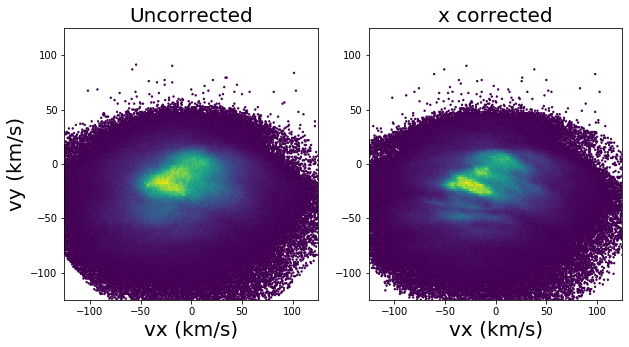

In [19]:
f, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(10,5))
gs=200
ax1.hexbin(test_v[:,0],test_v[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax1.set_title('Uncorrected',fontsize=20)
ax1.set_xlabel('vx (km/s)',fontsize=20)
ax1.set_ylabel('vy (km/s)',fontsize=20)
ax1.set_xlim(-125,125)
ax1.set_ylim(-125,125)
ax2.hexbin(fixx[:,0],fixx[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax2.set_title('x corrected',fontsize=20)
ax2.set_xlabel('vx (km/s)',fontsize=20)
ax2.set_xlim(-125,125)
ax2.set_ylim(-125,125)
plt.show()

In [27]:
make_anim_justx(XX,VV,tensors,myspace)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


73353 stars in wedge 0


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


74931 stars in wedge 1


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


74560 stars in wedge 2


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


75794 stars in wedge 3


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


77644 stars in wedge 4


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


79977 stars in wedge 5


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


81848 stars in wedge 6


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


83682 stars in wedge 7


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


85859 stars in wedge 8


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


86189 stars in wedge 9


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


86888 stars in wedge 10


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


87177 stars in wedge 11


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


90607 stars in wedge 12


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


93013 stars in wedge 13


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


93641 stars in wedge 14


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


90156 stars in wedge 15


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


84797 stars in wedge 16


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


81136 stars in wedge 17


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


79319 stars in wedge 18


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


81785 stars in wedge 19


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


84919 stars in wedge 20


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


88618 stars in wedge 21


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


91293 stars in wedge 22


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


92224 stars in wedge 23


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


92893 stars in wedge 24


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


91168 stars in wedge 25


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


89882 stars in wedge 26


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


87205 stars in wedge 27


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


84566 stars in wedge 28


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


82552 stars in wedge 29


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


80270 stars in wedge 30


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


77342 stars in wedge 31


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


73594 stars in wedge 32


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


69005 stars in wedge 33


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


68148 stars in wedge 34


/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


69736 stars in wedge 35


In [ ]:
make_anim_xv(XX,VV,tensors,myspace,tensorsxv,myspacexv)

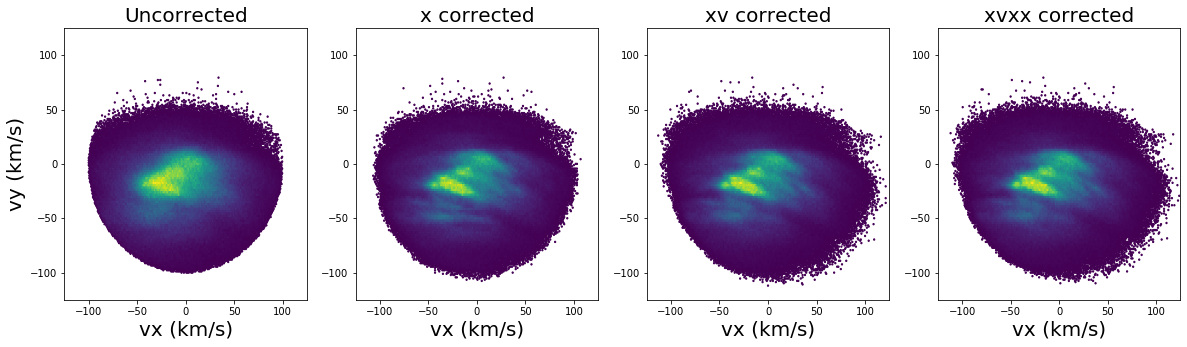

In [38]:
f, ((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4, figsize=(20,5))
gs=200
ax1.hexbin(test_v[:,0],test_v[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax1.set_title('Uncorrected',fontsize=20)
ax1.set_xlabel('vx (km/s)',fontsize=20)
ax1.set_ylabel('vy (km/s)',fontsize=20)
ax1.set_xlim(-125,125)
ax1.set_ylim(-125,125)
ax2.hexbin(fixx[:,0],fixx[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax2.set_title('x corrected',fontsize=20)
ax2.set_xlabel('vx (km/s)',fontsize=20)
ax2.set_xlim(-125,125)
ax2.set_ylim(-125,125)
ax3.hexbin(fixxv[:,0],fixxv[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax3.set_title('xv corrected',fontsize=20)
ax3.set_xlabel('vx (km/s)',fontsize=20)
ax3.set_xlim(-125,125)
ax3.set_ylim(-125,125)
ax4.hexbin(fixxvx[:,0],fixxvx[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax4.set_title('xvxx corrected',fontsize=20)
ax4.set_xlabel('vx (km/s)',fontsize=20)
ax4.set_xlim(-125,125)
ax4.set_ylim(-125,125)
#plt.savefig('comp64.pdf',bbox_inches='tight')
plt.show()